### Multi-Label Convolutional Neural Network (CNN)

**Author:** Tyler Gustafson

*Summer 2024*

**Github:** https://github.com/Tyler-Gustafson/Multi_label_convolutional_neural_network_CNN

#### ``Objectives``

**Overview:** This project utilizes a Multi-Label Convolutional Neural Network (CNN) to identify and classify Pokémon based on images. The model is trained on a diverse dataset of Pokémon images, allowing it to predict multiple labels such as type and evolutionary stage. The goal is to achieve high accuracy in multi-label classification, showcasing the potential of CNNs in image recognition tasks.

#### ``Motivations``
**Why is it important?**
- **Techinical Insight & Improvement**
    - *Evaluating Accuracy:* Assess the performance of machine learning models in identifying specific characters.
    - *Educational Value:* Practice principles of machine learning and deep learning, particularly CNNs
- **Practical Applications and Broader Impact**
    - *Environmental Monitoring:* Use image recognition to track and identify animals for habitat preservation.
    - *Autonomous Vehicles:* Improve self-driving cars' ability to recognize and respond to road objects for enhanced safety and efficiency.

- **Or for the everyday trainer: Pokédex Upgrade**
    - *Gotta Catch 'Em All… Correctly:* Finally make Professor Oak proud with a supercharged Pokedex that never gets a single entry wrong.



#### ``Classes (Targets)``
We understand there are several ways to identify pokemon beyond their actual name and in this analysis we have implemented multiple approaches to account for this along with using these to understand how different classes can enhance a models performance. Below are a list of classes that we have modeled that you will see referenced in the later stages of the notebook
- **Model 1**
    - *Class Targets:* All 151 pokemon
    - *Example:* Bulbasaur, Charmeleon, Dragonite
    - *Dataset:* Full dataset
- **Model 2**
    - *Class Targets:* By Poketype
    - *Example:* Grass, Fire, Dragon
    - *Dataset:* Full dataset
- **Model 3**
    - *Class Targets:* By Evolution Type
    - *Example:* Bulbasaur_Family, Charmander_Family, Dratini_Family
    - *Dataset:* Full dataset
- **Model 4**
    - *Class Targets:* By Legendary Status
    - *Example:* Non_Legendary, Non_Legendary, Legendary
    - *Dataset:* Full dataset

#### ``Data``

We started with a small data set from:
- Kaggle. (KVPRATAMA). Pokémon Images Dataset. Retrieved from
https://www.kaggle.com/datasets/kvpratama/pokemon-images-dataset

Then we grew the dataset to get more training data to be required this included:
- Kaggle. (LANCE ZHANG). Pokémon Classification. Retrieved from
https://www.kaggle.com/datasets/lantian773030/pokemonclassification
- Kaggle. (MIKOŁAJ KOLMAN). Pokemon Images, First Generation. Retrieved from
https://www.kaggle.com/datasets/mikoajkolman/pokemon-images-first-generation17000-files

- Google API Scraping
- Pokemon Website Database: Veekun. (n.d.). Pokémon Image Dataset. Retrieved from https://veekun.com/dex/downloads

From there we have reviewed and processed the images to ensure they are optimal for model training and evaluation. For example:
- Removed files that are from a unsupported format
- Removed images with poor image quality
- Removed images with numerous Pokemon
- Structured and organized images into to proper class subdirectories based on scenario and optimized for tensorflow and keras packages

*Please note this was a significant effort, but to simplify this notebook I included that work in a separate file*

**FOR PRACTICALITY PURPOSES AND LIMITED RESOURCES THIS DATASET WAS THEN REDUCED TO kvpratama Kaggle dataset AND veekun DATABASE**


#### ``Notebook Structure``
1. Imports
2. Initial Exploratory Data Analysis (EDA)
3. Data Ingestion and Initial Preprocessing
4. Data Augmentation
5. Baseline "Naive" Model
6. Building & Compiling Model
7. Training
8. Hyperparameter Tuning
9. Evaluation / Confusion Matrix / Learned Parameters Analysis
10. Understanding Model Performance Under Various Scenarios
    - **Model 1: Class Target** - Individual Pokemon
    - **Model 2: Class Target** - By Pokemon Type
    - **Model 3: Class Target** - By Evolution Group
    - **Model 4: Class Target** - By Legendary Pokemon
11. Generalization

## 1. Imports

Import the necessary libraries and **make sure to replace DATASET_PATH and the scenario paths with the path to the directories where you saved the data.**

In [1]:
# Standard Library Imports
import os
import glob
from PIL import Image
from collections import Counter
import string

# Third-Party Library Imports
import numpy as np
import pandas as pd
import seaborn as sns  # for nicer plots
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# Seaborn Settings
sns.set(style="darkgrid")  # default style

# TensorFlow and Keras Imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.optimizers import SGD, Adam

In [3]:
# Code if running locally

# Define image dataset path
dataset_path = r"C:\Users\tggus\OneDrive\Desktop\data\01_Scenario"

# Define Scenario Paths
dataset_path_Scenario_01 = r"C:\Users\tggus\OneDrive\Desktop\data\01_Scenario"
dataset_path_Scenario_02 = r"C:\Users\tggus\OneDrive\Desktop\data\02_Scenario"
dataset_path_Scenario_03 = r"C:\Users\tggus\OneDrive\Desktop\data\03_Scenario"
dataset_path_Scenario_04 = r"C:\Users\tggus\OneDrive\Desktop\data\04_Scenario"

## 2. Initial Exploratory Data Analysis (EDA)

Before diving into building our neural network it is important that we review our data to see if there are any immediate data quality issues that we should take care of in pre-processing. Below are counts of images by target class to ensure we have a balanced distribution of observations for the baseline scenario (Identifying pokemon 1-151) and that the data we have is sufficient enough for proper training for our model(s).

Below we can see sample images for the first 5 classes along with seeing only a handful of unique dimensions and a mean aspect ratio that approximately square (not really any outliers)

Unique dimensions: [[ 32  32]
 [ 40  30]
 [ 40  40]
 [ 48  48]
 [ 56  56]
 [ 64  64]
 [ 80  80]
 [ 96  96]
 [128 128]
 [256 256]]
Mean aspect ratio: 1.0055357017728261, Std aspect ratio: 0.0425980038283212


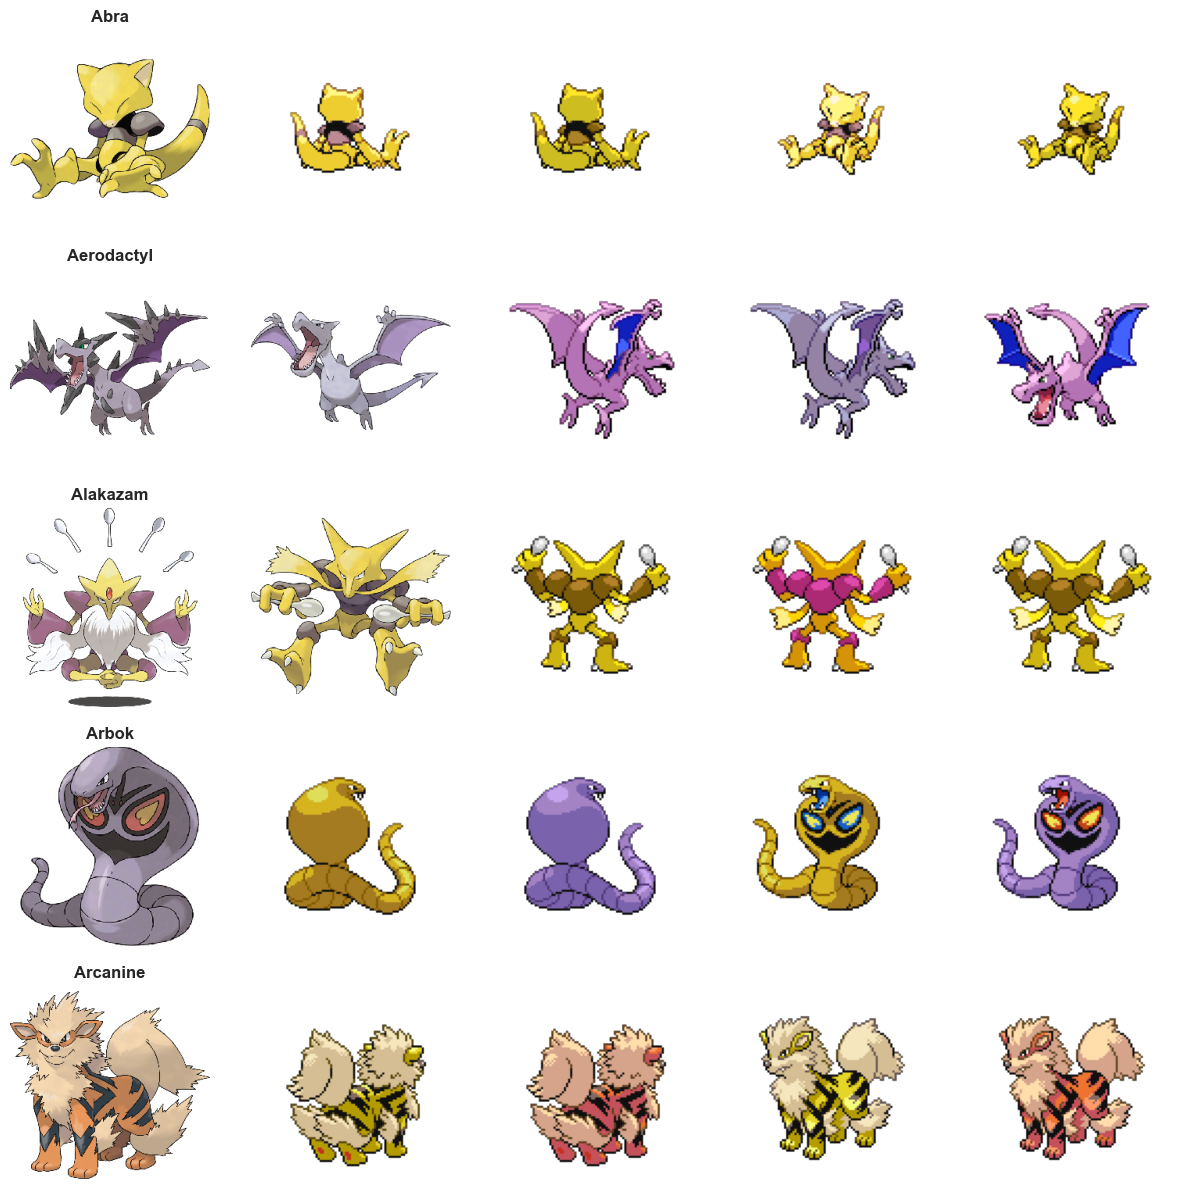

In [4]:
# EDA table: Provide sample images, list of unique dimensions of images and the mean aspect ratio

# Function to check image dimensions and aspect ratios
def check_image_dimensions(dataset_path):
    subdirectories = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    dimensions = []
    aspect_ratios = []

    for subdir in subdirectories:
        subdir_path = os.path.join(dataset_path, subdir)
        image_files = glob.glob(os.path.join(subdir_path, '*.*'))

        for image_file in image_files:
            with Image.open(image_file) as img:
                width, height = img.size
                dimensions.append((width, height))
                aspect_ratios.append(width / height)

    return dimensions, aspect_ratios

# Function to visualize sample images
def visualize_sample_images(dataset_path, num_samples=5):
    subdirectories = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    plt.figure(figsize=(15, 15))
    for idx, subdir in enumerate(subdirectories[:num_samples]):
        subdir_path = os.path.join(dataset_path, subdir)
        image_files = glob.glob(os.path.join(subdir_path, '*.*'))
        for j, image_file in enumerate(image_files[:num_samples]):
            plt.subplot(num_samples, num_samples, idx * num_samples + j + 1)
            img = Image.open(image_file)
            plt.imshow(img)
            plt.axis('off')
            if j == 0:
                plt.title(subdir, fontweight = 'bold')
    plt.show()

# Check image dimensions and aspect ratios
dimensions, aspect_ratios = check_image_dimensions(dataset_path_Scenario_01)

# Print summary statistics
dimensions_array = np.array(dimensions)
aspect_ratios_array = np.array(aspect_ratios)
print(f"Unique dimensions: {np.unique(dimensions_array, axis=0)}")
print(f"Mean aspect ratio: {np.mean(aspect_ratios_array)}, Std aspect ratio: {np.std(aspect_ratios_array)}")

# Visualize sample images
visualize_sample_images(dataset_path_Scenario_01)


In [5]:
# EDA Table: Provide the total number of images, average number of images per class and counts by class

# List all subdirectories in the dataset path and create a list to hold the data
def get_image_counts(dataset_path):
    subdirectories = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    data = []

    # Collect the number of images in each subdirectory
    for subdir in subdirectories:
        subdir_path = os.path.join(dataset_path, subdir)
        image_files = glob.glob(os.path.join(subdir_path, '*.*'))
        data.append({'Class': subdir, 'image_count': len(image_files)})

    return data

# Create a DataFrame from the collected data
data = get_image_counts(dataset_path)
df = pd.DataFrame(data)

# Find the class with the lowest image count
min_index = df['image_count'].idxmin()
class_with_lowest_count = df.loc[min_index, 'Class']
lowest_image_count = df.loc[min_index, 'image_count']

# Display the overview
print(f"Total Number of Images: {df['image_count'].sum()}")
print(f"Average Number of Images per Class: {round(df['image_count'].mean(), 2)}")
print(f"Class with the lowest image count: {class_with_lowest_count} with {lowest_image_count} images")

# Display the DataFrame sorted by image count
df_sorted = df.sort_values(by='image_count', ascending=True)
print(df_sorted)

Total Number of Images: 9514
Average Number of Images per Class: 63.01
Class with the lowest image count: Sandslash with 58 images
         Class  image_count
119  Sandslash           58
67      Krabby           59
66     Koffing           59
105    Poliwag           59
63      Kakuna           59
..         ...          ...
117    Rhyhorn           85
62     Kadabra           85
150      Zubat           85
50    Gyarados           86
2     Alakazam           86

[151 rows x 2 columns]


In [6]:
# EDA Chart: Display a chart of image counts by class and color code those taht are significantly below the mean

# Sort the DataFrame by image count for better visualization
df_sorted = df.sort_values(by='image_count', ascending=True)

# Calculate the average image count and standard deviation
average_count = df['image_count'].mean()
std_dev = df['image_count'].std()

# Determine the thresholds for highlighting
lower_threshold = average_count - std_dev
upper_threshold = average_count + std_dev

# Determine colors for the bars (using Pokémon colors)
colors = ['#FF6347' if x < lower_threshold else '#32CD32' if x > upper_threshold else '#1E90FF' for x in df_sorted['image_count']]

# Print classes that are below and above the thresholds
below_threshold = df_sorted[df_sorted['image_count'] < lower_threshold]
above_threshold = df_sorted[df_sorted['image_count'] > upper_threshold]

print("Classes below one standard deviation from the average:")
print(below_threshold)

print("\nClasses above one standard deviation from the average:")
print(above_threshold)

# Plot the bar chart with a white background
plt.figure(figsize=(10, 8), facecolor='white', edgecolor='white')
bars = plt.barh(df_sorted['Class'], df_sorted['image_count'], color=colors)
plt.axvline(x=average_count, color='gray', linestyle='--', linewidth=2, label=f'Average: {average_count:.2f}')
plt.xlabel('Count of Images', fontweight='bold', fontsize = 14)
plt.ylabel('Pokemon (Class)', fontweight='bold', fontsize = 14)
plt.title('Pokemon (Class) Distribution of Images', fontweight='bold', fontsize = 14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Set the axis background color to white
plt.gca().patch.set_facecolor('white')

# Adjust the font size of the labels
plt.yticks([])
plt.xticks(fontsize=10)

# Adjust y-axis limits to reduce padding
plt.ylim(-0.5, len(df_sorted) - 0.5)

# Add the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


Classes below one standard deviation from the average:
Empty DataFrame
Columns: [Class, image_count]
Index: []

Classes above one standard deviation from the average:
          Class  image_count
112      Raichu           75
120     Scyther           83
42        Gloom           84
43       Golbat           84
44      Goldeen           84
24        Doduo           84
23       Dodrio           84
115     Rattata           84
114    Raticate           84
122     Seaking           84
10   Butterfree           84
141   Vileplume           84
55        Hypno           84
73     Magikarp           85
103     Pikachu           85
139    Venusaur           85
116      Rhydon           85
117     Rhyhorn           85
62      Kadabra           85
150       Zubat           85
50     Gyarados           86
2      Alakazam           86


Great! The data is looking pretty good, but now it's important for us to determine the suitability of our image dataset, and we need to address two critical questions: 1) Does color play a significant role? 2) Are the classes distinct enough?

To answer the first question we will graph the classes by average color. We can see below that,

**It's clear that color really stands out as a key feature in our dataset**
- This is crucial because, if color did not provide meaningful differentiation, it could introduce noise and unnecessarily increase the dimensionality and complexity of our model.
- Holds true also for our other scenarios such as Pokémon type (Fire, Ghost, Poison, etc.)

c:\Users\tggus\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


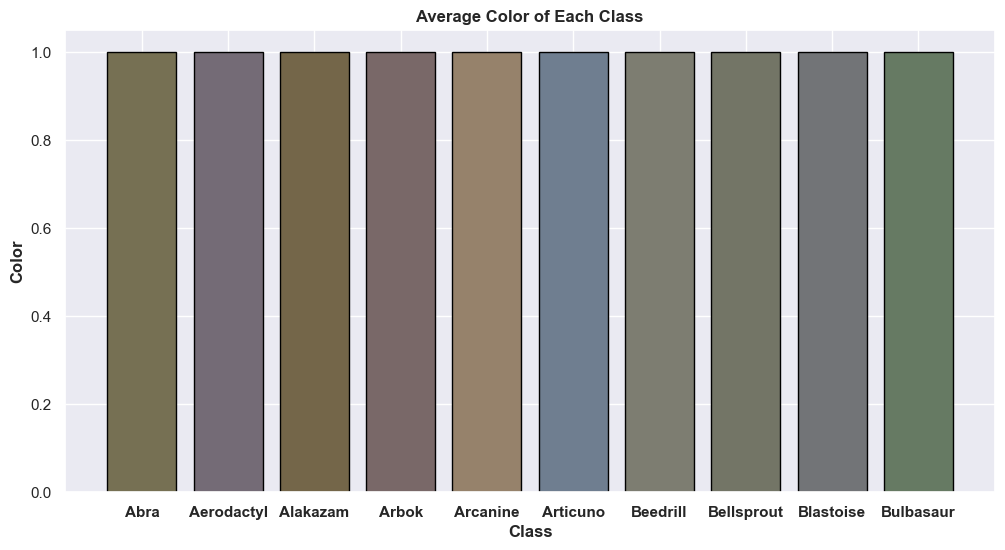

In [7]:
# EDA GRAPH: Average color by class

# Function to load and resize images from a folder
def load_and_resize_images_from_folder(folder, size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path).resize(size)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            images.append(np.array(img))
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    return images

# Function to compute the average color of a list of images
def compute_average_color(images):
    avg_color = np.mean([np.mean(image, axis=(0, 1)) for image in images], axis=0)
    return avg_color

# Function to plot the average colors of classes
def plot_average_colors(class_colors, class_names):
    fig, ax = plt.subplots(figsize=(12, 6))
    for class_name, color in zip(class_names, class_colors):
        ax.bar(class_name, 1, color=np.array(color)/255, edgecolor='black')
    ax.set_title('Average Color of Each Class', fontweight = 'bold')
    ax.set_ylabel('Color', fontweight = 'bold')
    ax.set_xlabel('Class', fontweight = 'bold')
    plt.xticks(rotation=0, fontweight = 'bold')
    plt.show()

# Load images and compute average colors for each class
class_names = os.listdir(dataset_path_Scenario_01)[:10] # limit to first 10 classes
class_colors = []

for cls in class_names:
    class_folder = os.path.join(dataset_path_Scenario_01, cls)
    images = load_and_resize_images_from_folder(class_folder)
    if images:
        avg_color = compute_average_color(images)
        class_colors.append(avg_color)
    else:
        print(f"No images found in class {cls}")

# Plot average colors
plot_average_colors(class_colors, class_names)


Perfect, now lets answer question 2 - are the image classes really distinct enough to make accurate predictions?

To answer this we will look at a t-SNE visualization of the images below. **It appears that we can see quite a difference. Here's what we're doing:**
- **PCA (Principal Component Analysis) Transformation** reduces the image dimensions to 50 components
- **T-SNE (t-distributed Stochastic Neighbor Embedding) Transformation** further reduces the image dimensions to 2
- **Clusters:** Images from the same class will cluster together if they are similar. Distinct clusters indicate that images of different classes have unique features.


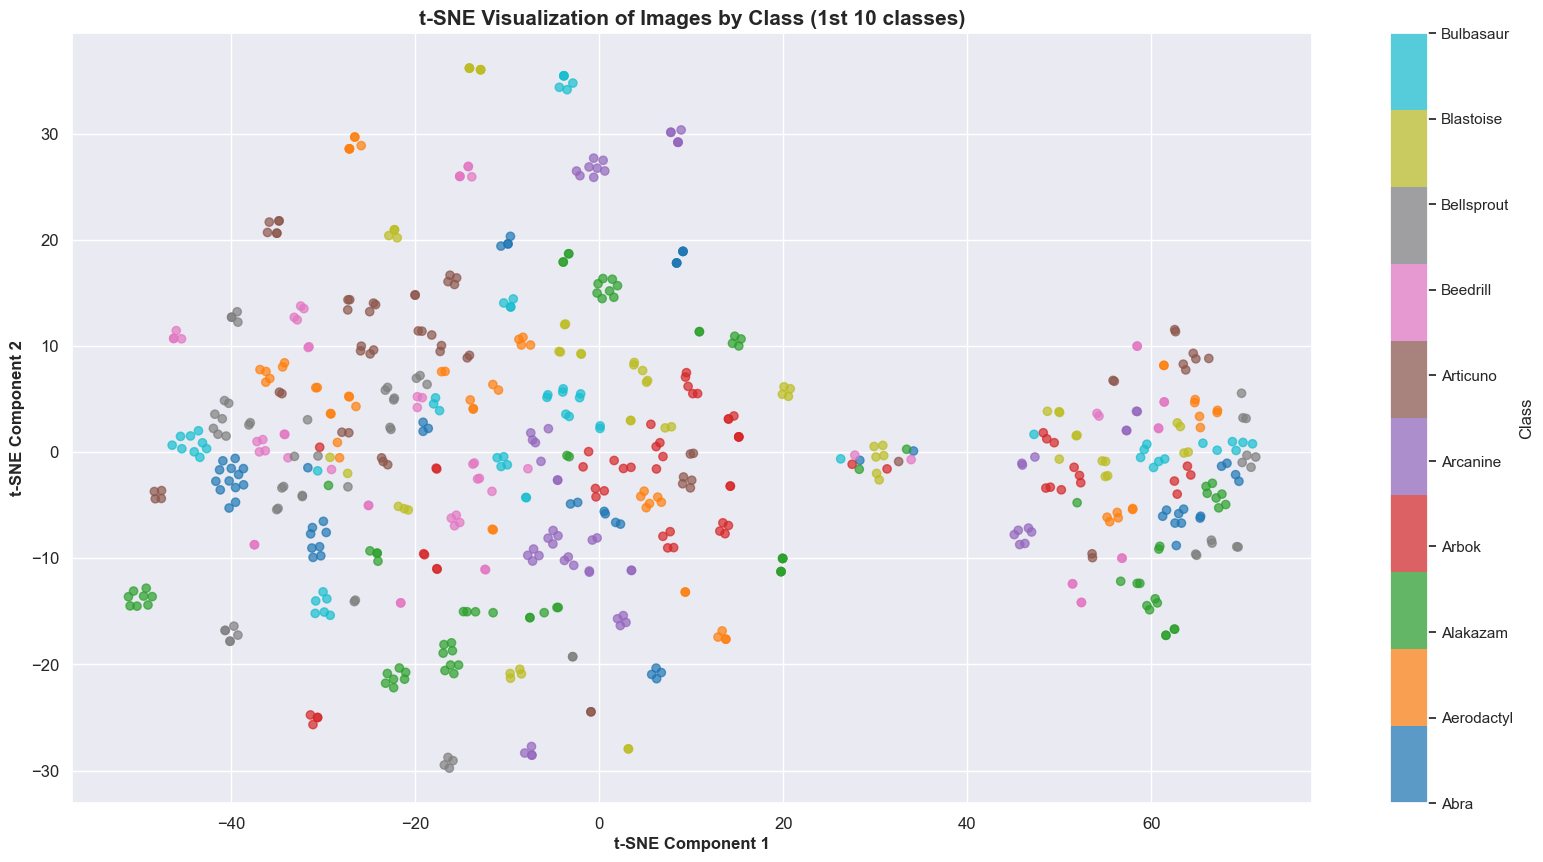

In [8]:
# EDA GRAPH: t-SNE Visualization of Image Dataset by Class: visualizes the images in a 2D scatter plot with points colored by class

# Function to load images and preprocess them
def load_images(dataset_path, num_classes=10):
    subdirectories = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    subdirectories = subdirectories[:num_classes]  # Limit to the first `num_classes` subdirectories
    images = []
    labels = []
    label_map = {subdir: idx for idx, subdir in enumerate(subdirectories)}

    for subdir in subdirectories:
        subdir_path = os.path.join(dataset_path, subdir)
        image_files = glob.glob(os.path.join(subdir_path, '*.*'))

        for image_file in image_files:
            with Image.open(image_file) as img:
                img = img.convert('RGB')
                img = img.resize((128, 128))  # Resize images to a consistent size
                img_array = np.array(img).flatten()  # Flatten the image into a 1D array
                images.append(img_array)
                labels.append(label_map[subdir])

    return np.array(images), np.array(labels), label_map

# Load and preprocess the images (limit to first 10 classes)
images, labels, label_map = load_images(dataset_path, num_classes=10)

# Apply PCA to reduce dimensionality (lower dimentional space of 50 dimensions)
pca = PCA(n_components=50)
images_pca = pca.fit_transform(images)

# Apply t-SNE to reduce dimensions (lowers dimentional space to 2D to allow graphing)
tsne = TSNE(n_components=2, random_state=0)
images_tsne = tsne.fit_transform(images_pca)

# Plot the t-SNE results
plt.figure(figsize=(20, 10))
scatter = plt.scatter(images_tsne[:, 0], images_tsne[:, 1], c=labels, cmap='tab10', alpha=0.7)
cbar = plt.colorbar(scatter, ticks=range(len(label_map)))
cbar.set_label('Class')
cbar.set_ticks(range(len(label_map)))
cbar.set_ticklabels(list(label_map.keys()))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('t-SNE Visualization of Images by Class (1st 10 classes)', fontsize=15, fontweight = 'bold')
plt.xlabel('t-SNE Component 1', fontsize=12, fontweight = 'bold')
plt.ylabel('t-SNE Component 2', fontsize=12, fontweight = 'bold')
plt.show()


Great! Now let's do it again with scenario 2 (pokemon type) to see if this also holds true for those classes.
We'll see that there seems to be a clear distinct difference in average color and t-SNE shows some general clustering, but we will have to keep our eye on it when we begin testing (hunch that the other model will perform better).

c:\Users\tggus\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


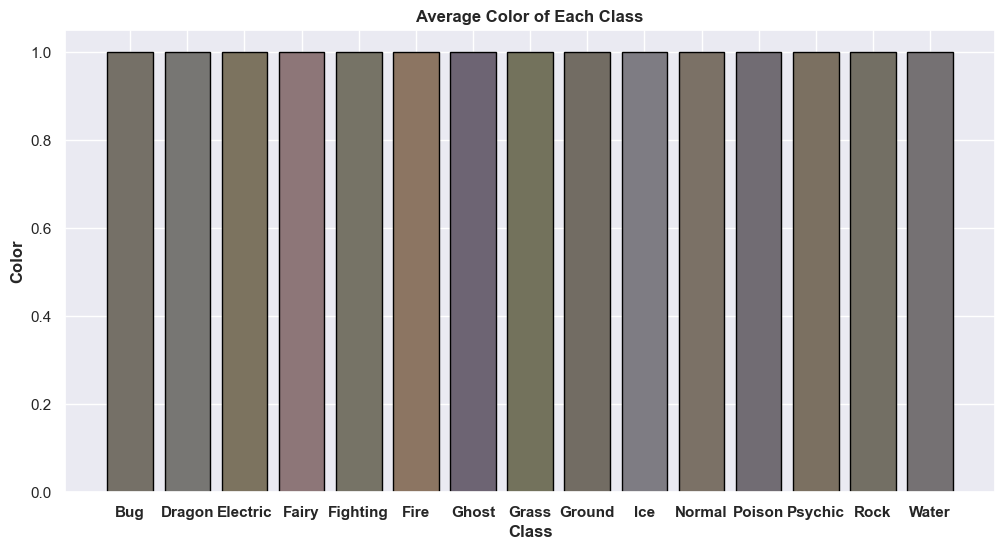

In [9]:
# EDA GRAPH: Average color by class (poketype)

# Load images and compute average colors for each class
class_names = os.listdir(dataset_path_Scenario_02)
class_colors = []

for cls in class_names:
    class_folder = os.path.join(dataset_path_Scenario_02, cls)
    images = load_and_resize_images_from_folder(class_folder)
    if images:
        avg_color = compute_average_color(images)
        class_colors.append(avg_color)
    else:
        print(f"No images found in class {cls}")

# Plot average colors
plot_average_colors(class_colors, class_names)


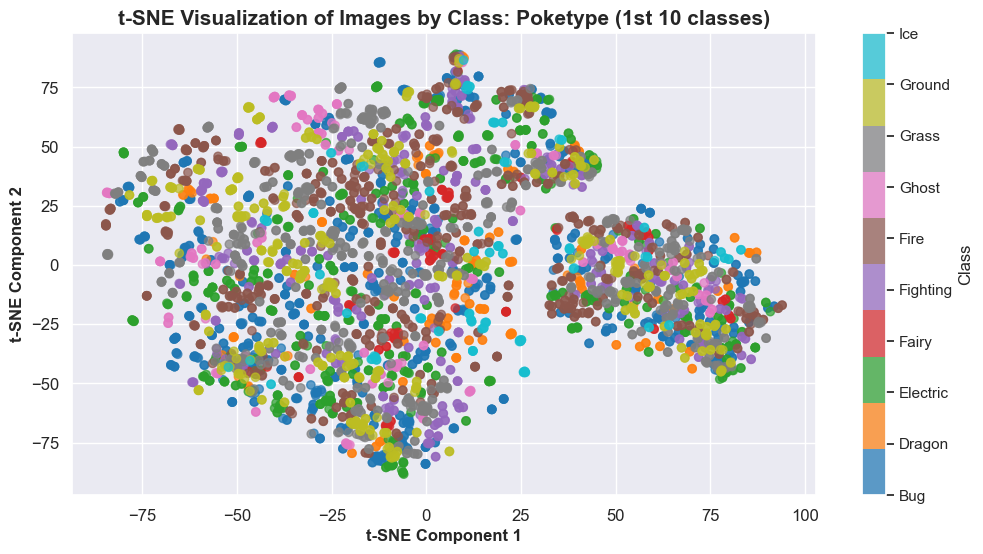

In [10]:
# EDA GRAPH: t-SNE Visualization of Image Dataset by Class: visualizes the images in a 2D scatter plot with points colored by class

# Load and preprocess the images (limit to first 10 classes)
images, labels, label_map = load_images(dataset_path_Scenario_02, num_classes=10)

# Apply PCA to reduce dimensionality (lower dimentional space of 50 dimensions)
pca = PCA(n_components=50)
images_pca = pca.fit_transform(images)

# Apply t-SNE to reduce dimensions (lowers dimentional space to 2D to allow graphing)
tsne = TSNE(n_components=2, random_state=0)
images_tsne = tsne.fit_transform(images_pca)

# Plot the t-SNE results
plt.figure(figsize=(12, 6))
scatter = plt.scatter(images_tsne[:, 0], images_tsne[:, 1], c=labels, cmap='tab10', alpha=0.7)
cbar = plt.colorbar(scatter, ticks=range(len(label_map)))
cbar.set_label('Class')
cbar.set_ticks(range(len(label_map)))
cbar.set_ticklabels(list(label_map.keys()))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('t-SNE Visualization of Images by Class: Poketype (1st 10 classes)', fontsize=15, fontweight = 'bold')
plt.xlabel('t-SNE Component 1', fontsize=12, fontweight = 'bold')
plt.ylabel('t-SNE Component 2', fontsize=12, fontweight = 'bold')
plt.show()


## 3. Data Ingestion and Initial Pre-processing

Now we can beging ingesting the data into tensforflow for preprocessing. The below code box if enable helps remove problematic images for tensorflow to avoid any errors.

In [11]:
# #Checks for problem images for tensorflow and removes them

# import tensorflow as tf

# # Identify problematic images
# def check_image_format(image_paths):
#     problematic_images = []
#     for path in image_paths:
#         try:
#             img = tf.io.read_file(path)
#             img = tf.image.decode_image(img)
#         except Exception as e:
#             problematic_images.append(path)
#             print(f"Problematic image: {path} - {e}")
#             os.remove(path)  # Delete the problematic image
#             print(f"Deleted problematic image: {path}")
#     return problematic_images

# # Get all image paths
# all_image_paths = []
# for root, dirs, files in os.walk(dataset_path):
#     for file in files:
#         all_image_paths.append(os.path.join(root, file))

# problematic_images = check_image_format(all_image_paths)

# print(f"Found {len(problematic_images)} problematic images.")

Tensorflow has a special function called "image_dataset_from_directory" that helps ingest large image datasets in a way that is efficent and optimized for Tensorflow. However, it is important to note that several things are going on in the code below:
- **Initial Preprocessing:** images are being standardized for a consistent size (128X128)
- **Train / Validation / Test split:** Images are being randomly assigned to a Train / Val / Test (60% / 20% / 20%) group for modeling
- **Batch_size:** To further help with optimization within each group (i.e. Trian) images are placed into batches

Note in the intial split, tensorflow mentions that its split for train and validation, however, how our code is making this initial split train / test split (the step imediately after splits the training data again for validation so we have all three groups).

In [12]:
# Data Ingestion: Splitting Training and Test Data & Initial PreProcessing

# Define parameters
batch_size = 32
img_height = 128 #256
img_width = 128 #256
train_test_split = .2 # 20% for test
seed = 1234

# Split the dataset into training and test sets
train_ds_temp = image_dataset_from_directory(
    dataset_path,
    validation_split=train_test_split,  # 20% for test set
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=train_test_split,  # 20% for test set
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Calculate the number of batches in the training dataset
num_batches = tf.data.experimental.cardinality(train_ds_temp).numpy()

# Calculate the number of batches for 75% and 25%
num_batches_75 = int(num_batches * 0.75)
num_batches_25 = num_batches - num_batches_75

# Split the training dataset into 75% and 25%
train_ds = train_ds_temp.take(num_batches_75)
val_ds = train_ds_temp.skip(num_batches_75)

# Count the number of files in each dataset
num_files_train = sum(1 for _ in train_ds.unbatch())
num_files_val = sum(1 for _ in val_ds.unbatch())
num_files_test = sum(1 for _ in test_ds.unbatch())

# Display the structure of the dataset
print('NOTE THE ABOVE VALIDATION MEANS TEST DATA')
print('-------------------------')
print(f"Train dataset: {train_ds}")
print(f"Val dataset: {val_ds}")
print(f"Test dataset: {test_ds}")

# Example: Inspect the class names
class_names = train_ds_temp.class_names
print('-------------------------')
print(f"Class names: {class_names}")
print('-------------------------')

print(f"Number of files in train_ds: {num_files_train}")
print(f"Number of files in val_ds: {num_files_val}")
print(f"Number of files in test_ds: {num_files_test}")


Found 9514 files belonging to 151 classes.
Using 7612 files for training.
Found 9514 files belonging to 151 classes.
Using 1902 files for validation.
NOTE THE ABOVE VALIDATION MEANS TEST DATA
-------------------------
Train dataset: <_TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Val dataset: <_SkipDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Test dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
-------------------------
Class names: ['Abra', 'Aerodactyl', 'Alakazam', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 

In [13]:
# Calculate the number of batches in train_ds, val_ds and test_ds for reference
num_batches_train_ds = tf.data.experimental.cardinality(train_ds).numpy()
num_batches_val_ds = tf.data.experimental.cardinality(val_ds).numpy()
num_batches_test_ds = tf.data.experimental.cardinality(test_ds).numpy()

print(f"Number of batches in train_ds: {num_batches_train_ds}")
print(f"Number of batches in val_ds: {num_batches_val_ds}")
print(f"Number of batches in test_ds: {num_batches_test_ds}")

Number of batches in train_ds: 178
Number of batches in val_ds: 60
Number of batches in test_ds: 60


## 4. Data Augmentation

A note on Data Augmentation we originally conducted augmentations in real time as keras was processing, but that led to a validation curve performing better than our training loss curve. So now below we are doing the augmentation prior to compiling and training the model.
- **Rescaling:** rescale pixel values to range [0,1]
- **RandomFlip:** Randomly flips images horizontally to help model learn
- **RandomRotation:** Rotates images at random between 0 and 20 degrees again to help model learn with each epoch

(-0.5, 127.5, 127.5, -0.5)

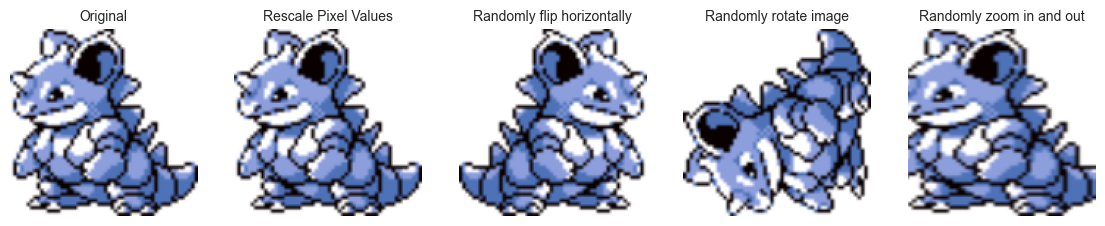

In [14]:
"""
Data Augmentation

Example of the data image preprocessing for one image
"""
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# Get the first batch
first_batch = train_ds.take(1).get_single_element()

# Unpack the batch into images and labels
images, labels = first_batch

# Get the first image from the batch
image = images[0]
first_label = labels[0]

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(array_to_img(image))
ax.set_title('Original', size=10);
ax.axis('off')

# Rescale pixel values to range [0,1]
ax = fig.add_subplot(1, 5, 2)
img_rescale = tf.cast(image, tf.float32) / 255.0
ax.imshow(array_to_img(img_rescale))
ax.set_title('Rescale Pixel Values', size=10);
ax.axis('off')


# Randomly flip images horizontally
# Temporarily unset the seed to observe different results
tf.random.set_seed(None)
ax = fig.add_subplot(1, 5, 3)
image_flip = tf.image.random_flip_left_right(image)
ax.imshow(array_to_img(image_flip))
ax.set_title('Randomly flip horizontally', size=10);
ax.axis('off')
# Reset the seed for reproducibility in other parts of the code
tf.random.set_seed(1234)

# Randomly rotate images between 0 and 20 degrees
ax = fig.add_subplot(1, 5, 4)
image_rot = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
ax.imshow(array_to_img(image_rot))
ax.set_title('Randomly rotate image', size=10);
ax.axis('off')

# Randomly zoom in and out
ax = fig.add_subplot(1, 5, 5)
zoom_layer = tf.keras.layers.RandomZoom(height_factor=0.0, width_factor=0.2)  # Zoom between 0% and 20%
input_img = tf.expand_dims(image, axis=0)  # Add batch dimension
out_img = zoom_layer(input_img)[0]  # Remove batch dimension
ax.imshow(array_to_img(out_img))
ax.set_title('Randomly zoom in and out', size=10);
ax.axis('off')


In [15]:
def data_augmentation(X, y, data_partition='train'):
    """
    Apply transformations and augmentations to training, validation, and test data

    Parameters:
    X  (np.ndarray): Images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)
    data_partition (str): "train"

    Returns:
    X (np.ndarray): Preprocessed images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)
    """
    tf.random.set_seed(None)
    IMAGE_SIZE = (128, 128)
    CONTRAST_FACTOR = 3
    DELTA = 0.3
    ### image transformation on training, validation, and test data ###
    ###################################################################
    # image rescale
    X = tf.cast(X, tf.float32) / 255.0
    X = tf.image.resize(X, size=IMAGE_SIZE)

    # Randomly flip images horizontally
    X_train_augm = tf.image.random_flip_left_right(X)

    # Randomly rotate images between 0 and 20 degrees
    X_train_augm = tf.image.rot90(X_train_augm, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Randomly zoom in and out
    X_train_augm = tf.image.random_flip_left_right(X_train_augm)

    # concatenate original X_train and augmented X_train data
    X_train_augm = tf.concat([X_train, X_train_augm],axis=0)

    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)

    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    return X_train, y_train

In [16]:
"""
We will not be moving forward with this pre-processing for our model because
our simplified sprite image dataset is actually very well structured with
minimum variation so by introducing adjustments to our training set that
isn't something seen in our validation and test dataset the model is learning
features that aren't seen in the real world data.
In other words, its learning additional complexity that isn't there.
"""
"""
# Initialize lists to store all images and labels
all_images_train = []
all_labels_train = []

# Iterate over the train dataset and collect images and labels
for batch in train_ds:
    images, labels = batch
    all_images_train.append(images.numpy())
    all_labels_train.append(labels.numpy())

# Convert lists to numpy arrays
X_train = np.concatenate(all_images_train, axis=0)
y_train = np.concatenate(all_labels_train, axis=0)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train, y_train = data_augmentation(X_train, y_train)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")

# Create a TensorFlow dataset from the numpy arrays
train_ds_reconstructed = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# Batch the dataset
train_ds_reconstructed = train_ds_reconstructed.batch(batch_size)

# Prefetch the dataset (optional, for performance)
train_ds_reconstructed = train_ds_reconstructed.prefetch(buffer_size=tf.data.AUTOTUNE)
"""

'\n# Initialize lists to store all images and labels\nall_images_train = []\nall_labels_train = []\n\n# Iterate over the train dataset and collect images and labels\nfor batch in train_ds:\n    images, labels = batch\n    all_images_train.append(images.numpy())\n    all_labels_train.append(labels.numpy())\n\n# Convert lists to numpy arrays\nX_train = np.concatenate(all_images_train, axis=0)\ny_train = np.concatenate(all_labels_train, axis=0)\n\nprint("X_train shape:", X_train.shape)\nprint("y_train shape:", y_train.shape)\n\nX_train, y_train = data_augmentation(X_train, y_train)\n\nprint(f"X_train shape {X_train.shape}")\nprint(f"y_train shape {y_train.shape}")\n\n# Create a TensorFlow dataset from the numpy arrays\ntrain_ds_reconstructed = tf.data.Dataset.from_tensor_slices((X_train, y_train))\n\n# Batch the dataset\ntrain_ds_reconstructed = train_ds_reconstructed.batch(batch_size)\n\n# Prefetch the dataset (optional, for performance)\ntrain_ds_reconstructed = train_ds_reconstructed.p

## 5. Baseline "Naive" Model

Next in order to get a sense of how our model is performing we need to understand what the "baseline" is so we have a benchmark to compare our performance with. Below are the steps we took for this:

``Step 1 Identify the Most Common Class:``

* Count Images: Count the number of images in each class directory.
* Find Most Common Class: Identify the class with the highest count of images.

``Step 2 Prepare Data:``

* Encode Class Labels: Convert class names to numerical indices.
* Most Common Class Index: Get the index of the most common class.

``Step 3 Define Baseline Naive Model Function:``

* Extract True Labels: Get the actual labels (y_true) from the dataset.
* Predict Most Common Class: Create predictions (y_pred) where all predictions are the most common class.
* Calculate Accuracy: Use the accuracy_score function to compute the accuracy of these predictions.

``Evaluate Model:``

* Calculate Baseline Accuracy: Apply the function to the validation dataset and print the accuracy.

In [17]:
# CALCULATE BASELINE MODEL PREDICTION

# Step 1
# Determine the most common class
most_common_class = df_sorted.iloc[-1]['Class']

print(f"Most common class: {most_common_class}")
print(f"Number of images in most common class: {df_sorted.iloc[-1]['image_count']}")

# Determine the top 10 most common classes
top_10_common_classes = df_sorted.iloc[-10:][['Class', 'image_count']].sort_values(by='image_count', ascending=False)
print("\nTop 10 most common classes:")
print(top_10_common_classes)

# Step 2
# Encode class labels
class_names = df['Class'].tolist()
class_to_index = {cls: idx for idx, cls in enumerate(class_names)}
most_common_class_index = class_to_index[most_common_class]

# Step 3
# Define the baseline naive model function
def baseline_naive_model(dataset, most_common_class_index):
    y_true = np.concatenate([y for x, y in dataset], axis=0)  # Extract true labels
    y_pred = np.full_like(y_true, most_common_class_index)  # Predict the most common class index for all samples
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

# Step 4
# Calculate the baseline accuracy on the validation dataset
baseline_accuracy = baseline_naive_model(val_ds, most_common_class_index)
print(f"Baseline Naive Model Accuracy: {baseline_accuracy * 100:.2f}%")

Most common class: Alakazam
Number of images in most common class: 86

Top 10 most common classes:
        Class  image_count
50   Gyarados           86
2    Alakazam           86
73   Magikarp           85
103   Pikachu           85
139  Venusaur           85
116    Rhydon           85
117   Rhyhorn           85
62    Kadabra           85
150     Zubat           85
55      Hypno           84
Baseline Naive Model Accuracy: 0.84%


## 6. Building & Compiling Model (Convolutional Neural Network)

Here we can now compile our model using tensorflow and keras.

**Model Hidden Convolutional Layers:**

The hidden layers in this model are composed of several convolutional blocks, each designed to extract and learn various features from the input images.
- **Convolutional Blocks**
    - Multiple layers with varying filter sizes (32, 64, 128, 256)
    - Activation function: ReLU
    - Each block includes BatchNormalization and MaxPooling layers for normalization and spatial reduction.
- **Fully Connected Block**
    - Flatten layer to convert 3D feature maps to a 1D vector
    - Dense layer with 512 units and ReLU activation
    - Dropout layer with a dropout rate of 0.5 for regularization

**Output Layer:**

The output layer provides the final classification probabilities for each class (the model's prediction)
- **Dense layer:** with units equal to the number of output classes
- **Activiation function:** softmax (to convert outputs to a probability distro)

In [18]:
# Build Convolutional Nerual Network (CNN) Model

def build_model(input_shape,n_classes,
                optimizer,
                learning_rate,
                metric,
                activation = 'relu'):
    """Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of output classes in the dataset.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.
    metric: The desired metric.

    Returns:
    model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    model = tf.keras.Sequential()

    # Input layer with data augmentation
    model.add(Input(shape=input_shape))

    # 1st Convolutional layer with 32 filters and ReLU activation
    model.add(Conv2D(32, (3, 3), activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # 2nd Convolutional layer with 64 filters and ReLU activation
    model.add(Conv2D(64, (3, 3), activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # 3rd Convolutional layer with 128 filters and ReLU activation
    model.add(Conv2D(128, (3, 3), activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # 4th Convolutional layer with 256 filters and ReLU activation
    model.add(Conv2D(256, (3, 3), activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Fully connected block
    model.add(Flatten()) # Flatten the feature maps into a 1D vector
    model.add(Dense(512, activation=activation)) # Fully connected layer with 512 units and ReLU activation
    model.add(Dropout(0.5)) #Dropout for regularization to prevent overfitting

    # Output layer with softmax activation function
    model.add(tf.keras.layers.Dense(
        units=n_classes,        # output dim
        use_bias=True,          # use a bias (intercept) param
        activation='softmax'    # Outputs sum to 1 so they can be interpreted as probabilities (Target class being the highest)
    ))

    # Configure optimizer to allow for adam or SGD
    if optimizer.lower() == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate) # holds rate constant
    elif optimizer.lower() == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) # adjusts learning rate throughout training
    else:
        raise ValueError("Unsupported optimizer. Use 'SGD' or 'Adam'.")

    # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
    model.compile(
        optimizer = optimizer,
        loss = 'sparse_categorical_crossentropy',
        metrics = [metric]
    )

    return model

## 7. Model Training

Now we can begin training our model - Note with the trian and evaluate function has a built in graph function (we will remove this later when using it for different scenarios).

In [19]:
# FUNCTION - train and evaluate model also includes a graph function

def train_and_evaluate(train_ds,
                       val_ds,
                       input_shape,
                       n_classes,
                       optimizer,
                       learning_rate,
                       metric,
                       num_epochs):
    """Train and evaluate the model.

    Args:
    train_ds: Training dataset.
    val_ds: Validation dataset.
    input_shape: Shape of the input data.
    n_classes: Number of output classes.
    optimizer: Optimizer to use (SGD, Adam).
    learning_rate: Learning rate for the optimizer.
    metric: Metric to evaluate the model.
    num_epochs: Number of epochs for training.

    Returns:
    model: Trained model.
    """
    # Build the model
    model = build_model(input_shape=input_shape,
                        n_classes=n_classes,
                        optimizer=optimizer,
                        metric=metric,
                        learning_rate=learning_rate)

    # Train the model
    print('Training the model...')
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=num_epochs,
        verbose=1
    )

    # Plot training & validation accuracy values
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(num_epochs)

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    print('Training accuracy: %1.4f' % acc[-1])
    print('Validation accuracy: %1.4f' % val_acc[-1])

    return model




Training the model...
Epoch 1/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 45s 240ms/step - accuracy: 0.0265 - loss: 5.6598 - val_accuracy: 0.1091 - val_loss: 4.4777
Epoch 2/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 45s 253ms/step - accuracy: 0.1382 - loss: 4.1096 - val_accuracy: 0.3309 - val_loss: 3.4040
Epoch 3/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 40s 227ms/step - accuracy: 0.3362 - loss: 3.0327 - val_accuracy: 0.4932 - val_loss: 2.5438
Epoch 4/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 40s 223ms/step - accuracy: 0.5167 - loss: 2.0229 - val_accuracy: 0.6247 - val_loss: 1.9192
Epoch 5/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 41s 228ms/step - accuracy: 0.7055 - loss: 1.2652 - val_accuracy: 0.6889 - val_loss: 1.5518
Epoch 6/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 42s 233ms/step - accuracy: 0.7989 - loss: 0.7977 - val_accuracy: 0.7359 - val_loss: 1.2896
Epoch 7/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 41s 231ms/step - accuracy: 0.8808 - loss: 0.5060 - val_accuracy: 0.7704 - val_loss: 1.1480
Epoch 8/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 42s 235ms/step - acc

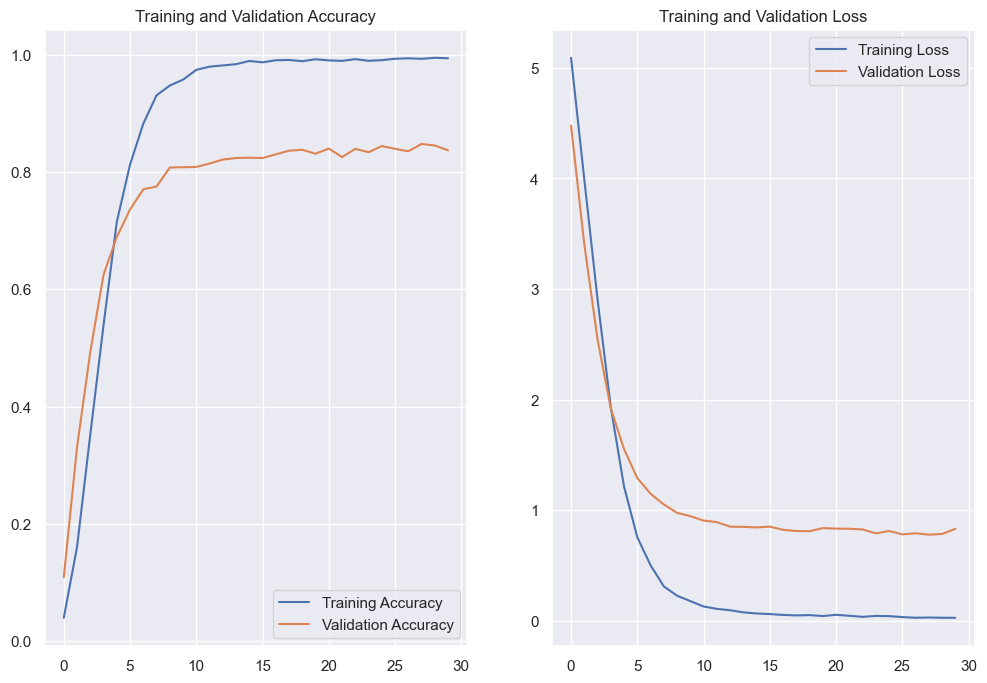

Training accuracy: 0.9937
Validation accuracy: 0.8366


In [20]:
# Train and Evaluate
input_shape = (img_height, img_width, 3)
n_classes = len(class_names)
optimizer = "Adam"
learning_rate = .0001
metric='accuracy'
num_epochs=30
model = train_and_evaluate(train_ds, val_ds, input_shape, n_classes, optimizer, learning_rate, metric, num_epochs)


## 8. Hyperparameter Tuning

Next we will will display all the different hyperparameter tuning results that we had to ensure we have the optimal settings for our model. You will see that the above settings had the best performing metrics for training accuracy and validation accuracy

| Scenario Settings | Model       | Activation | Optimizer | Learning Rate | Final Training Accuracy | Final Validation Accuracy | Final Training Loss | Final Validation Loss | Number of Parameters |
|----------|-------------|------------|-----------|---------------|-------------------------|---------------------------|---------------------|-----------------------|----------------------|
| A        | small_model | tanh       | sgd       | 0.0010        | 0.953476                | 0.794363                  | 0.510748            | 1.331519              | 29588951             |
| B        | small_model | relu       | sgd       | 0.0010        | 0.977001                | 0.825157                  | 0.183529            | 0.954671              | 29588951             |
| C        | small_model | relu       | Adam      | 0.0001        | 0.982795                | 0.837161                  | 0.067331            | 0.995771              | 29588951             |
| D        | full_model  | tanh       | sgd       | 0.0010        | 0.387816                | 0.415449                  | 2.833998            | 2.913388              | 5186903              |
| E        | full_model  | tanh       | Adam      | 0.0001        | 0.998420                | 0.838727                  | 0.068389            | 0.831619              | 5186903              |
| F        | full_model  | relu       | Adam      | 0.0001        | 0.989500                | 0.847100                  | 0.069008            | 0.802359              | 5186903              |



In [21]:
# FUNCTION - build model for for a 2 layer cnn model

def build_small_model(input_shape,n_classes,
                optimizer,
                learning_rate,
                metric,
                activation = 'relu'):
    """Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of output classes in the dataset.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.
    metric: The desired metric.

    Returns:
    model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    model = tf.keras.Sequential()

    # Input layer with data augmentation
    model.add(Input(shape=input_shape))

    # 1st Convolutional layer with 32 filters and ReLU activation
    model.add(Conv2D(32, (3, 3), activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # 2nd Convolutional layer with 64 filters and ReLU activation
    model.add(Conv2D(64, (3, 3), activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Fully connected block
    model.add(Flatten()) # Flatten the feature maps into a 1D vector
    model.add(Dense(512, activation=activation)) # Fully connected layer with 512 units and ReLU activation
    model.add(Dropout(0.5)) #Dropout for regularization to prevent overfitting

    # Output layer with softmax activation function
    model.add(tf.keras.layers.Dense(
        units=n_classes,        # output dim
        use_bias=True,          # use a bias (intercept) param
        activation='softmax'    # Outputs sum to 1 so they can be interpreted as probabilities (Target class being the highest)
    ))

    # Configure optimizer to allow for adam or SGD
    if optimizer.lower() == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate) # holds rate constant
    elif optimizer.lower() == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) # adjusts learning rate throughout training
    else:
        raise ValueError("Unsupported optimizer. Use 'SGD' or 'Adam'.")

    # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
    model.compile(
        optimizer = optimizer,
        loss = 'sparse_categorical_crossentropy',
        metrics = [metric]
    )

    return model

In [22]:
# FUNCTION - create to evaluate different hyper parameter approaches

def hyperparameter_train_and_evaluate(train_ds, val_ds, input_shape, n_classes, optimizer, learning_rate, metric, num_epochs, activation, model_type):
    """Train and evaluate the model.

    Args:
    train_ds: Training dataset.
    val_ds: Validation dataset.
    input_shape: Shape of the input data.
    n_classes: Number of output classes.
    optimizer: Optimizer to use (SGD, Adam).
    learning_rate: Learning rate for the optimizer.
    metric: Metric to evaluate the model.
    num_epochs: Number of epochs for training.
    activation: Activation function to use in the model.
    model_type: Type of model to use ('full_model' or 'small_model').

    Returns:
    model: Trained model.
    history: Training history of the model.
    """

    # Option of whether to use small 2 layer model or full 4 layer model
    if model_type == "full_model":
        model = build_model(input_shape=input_shape,
                            n_classes=n_classes,
                            optimizer=optimizer,
                            metric=metric,
                            learning_rate=learning_rate,
                            activation=activation)
    else:
        model = build_small_model(input_shape=input_shape,
                                  n_classes=n_classes,
                                  optimizer=optimizer,
                                  metric=metric,
                                  learning_rate=learning_rate,
                                  activation=activation)

    # Train the model
    print('Training the model...')
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=num_epochs,
        verbose=1
    )

    return model, history

In [23]:
# Run different hyperparameter scenarios and return data frame

# List of scenarios to evaluate
scenarios = [
    {"hidden_layer_sizes": 'small_model', "activation": "tanh", "optimizer": "sgd", "learning_rate": .001},
    {"hidden_layer_sizes": 'small_model', "activation": "relu", "optimizer": "sgd", "learning_rate": .001},
    {"hidden_layer_sizes": 'small_model', "activation": "relu", "optimizer": "Adam", "learning_rate": .0001},
    {"hidden_layer_sizes": 'full_model', "activation": "tanh", "optimizer": "sgd", "learning_rate": .001},
    {"hidden_layer_sizes": 'full_model', "activation": "tanh", "optimizer": "Adam", "learning_rate": .0001},
    {"hidden_layer_sizes": 'full_model', "activation": "relu", "optimizer": "Adam", "learning_rate": .0001},
]

# Train and Evaluate
input_shape = (img_height, img_width, 3)
n_classes = len(class_names)
metric = 'accuracy'
num_epochs = 15

# Storage for all scenarios
all_acc = []
all_val_acc = []
all_loss = []
all_val_loss = []
results = []

# Iterate through each scenario
n = 1
for scenario in scenarios:
    print(f'Scenario {n}:')
    model, history = hyperparameter_train_and_evaluate(
        train_ds,
        val_ds,
        input_shape,
        n_classes,
        optimizer=scenario['optimizer'],
        learning_rate=scenario['learning_rate'],
        metric=metric,
        num_epochs=num_epochs,
        model_type=scenario['hidden_layer_sizes'],
        activation=scenario['activation']
    )
    print(f'Scenario {n}:')
    print(scenario)
    print('-------------------')

    # Collect the history data
    all_acc.append(history.history['accuracy'])
    all_val_acc.append(history.history['val_accuracy'])
    all_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])

    # Record final accuracy and loss for the table
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    num_params = model.count_params()
    results.append({
        'Scenario': n,
        'Model': scenario['hidden_layer_sizes'],
        'Activation': scenario['activation'],
        'Optimizer': scenario['optimizer'],
        'Learning Rate': scenario['learning_rate'],
        'Final Training Accuracy': final_train_acc,
        'Final Validation Accuracy': final_val_acc,
        'Final Training Loss': final_train_loss,
        'Final Validation Loss': final_val_loss,
        'Number of Parameters': num_params
    })

    n += 1

# Create a DataFrame for the results
results_df = pd.DataFrame(results)
results_df


Scenario 1:
Training the model...
Epoch 1/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 36s 198ms/step - accuracy: 0.0136 - loss: 5.5324 - val_accuracy: 0.0376 - val_loss: 4.8022
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 36s 202ms/step - accuracy: 0.0614 - loss: 4.7851 - val_accuracy: 0.1096 - val_loss: 4.4195
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 194ms/step - accuracy: 0.1607 - loss: 4.0361 - val_accuracy: 0.1148 - val_loss: 4.4512
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 197ms/step - accuracy: 0.2451 - loss: 3.6158 - val_accuracy: 0.2046 - val_loss: 3.9122
Epoch 5/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 195ms/step - accuracy: 0.2927 - loss: 3.3165 - val_accuracy: 0.4061 - val_loss: 3.1389
Epoch 6/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 36s 201ms/step - accuracy: 0.4216 - loss: 2.7626 - val_accuracy: 0.3690 - val_loss: 3.2789
Epoch 7/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 37s 206ms/step - accuracy: 0.4988 - loss: 2.4713 - val_accuracy: 0.5391 - val_loss: 2.5027
Epoch 8/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 198ms

Scenario        Model Activation Optimizer  Learning Rate  \
0         1  small_model       tanh       sgd         0.0010   
1         2  small_model       relu       sgd         0.0010   
2         3  small_model       relu      Adam         0.0001   
3         4   full_model       tanh       sgd         0.0010   
4         5   full_model       tanh      Adam         0.0001   
5         6   full_model       relu      Adam         0.0001   

   Final Training Accuracy  Final Validation Accuracy  Final Training Loss  \
0                 0.926615                   0.756263             0.664965   
1                 0.983497                   0.824635             0.163665   
2                 0.974544                   0.837161             0.096045   
3                 0.327247                   0.379436             3.183657   
4                 0.999122                   0.854906             0.065042   
5                 0.985077                   0.824635             0.066861   

   Final Validation Loss  Number of Parameters  
0               1.471942              29588951  
1               0.952880              29588951  
2               0.991041              29588951  
3               3.198821               5186903  
4               0.744628               5186903  
5               0.846616               5186903

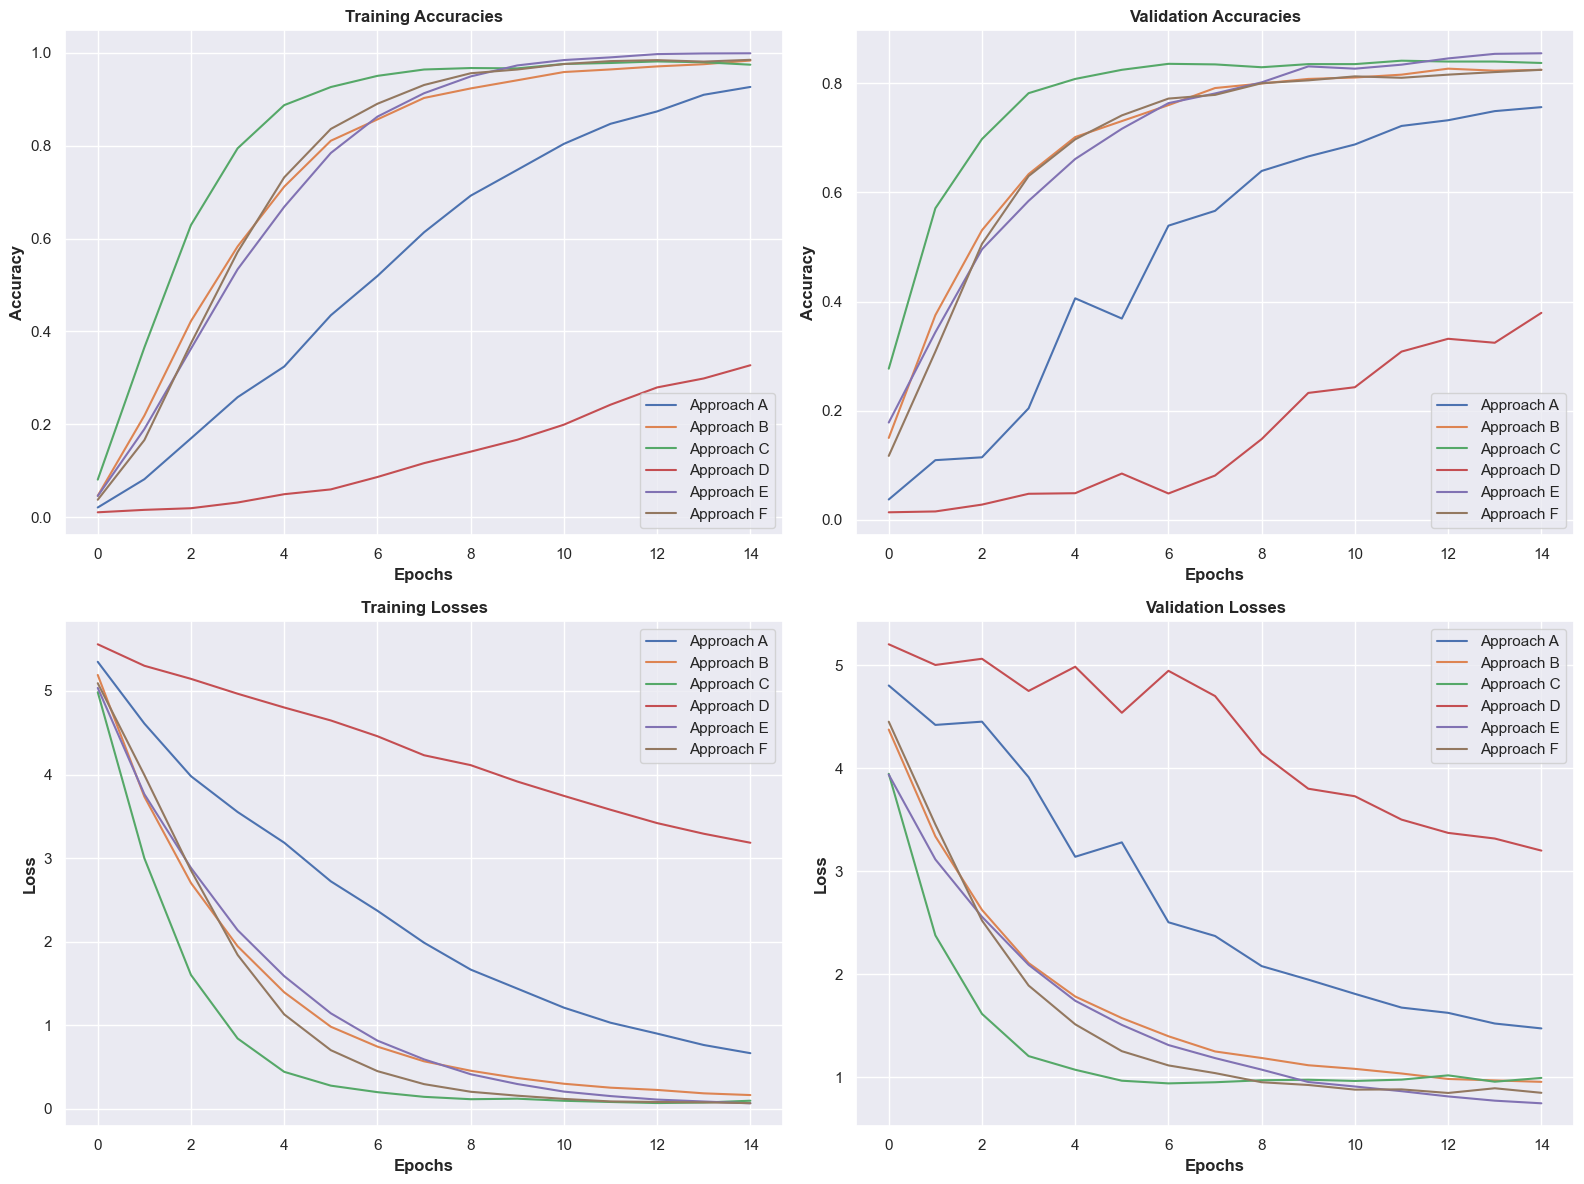

In [24]:
# GRAPH: Displays all the metrics for each of the different approaches

import string

# List of approach labels
approach_labels = list(string.ascii_uppercase)  # ['A', 'B', 'C', 'D', 'E', 'F', ...]

# Plotting
epochs_range = range(num_epochs)

plt.figure(figsize=(16, 12))

# Plot all training accuracies
plt.subplot(2, 2, 1)
for i, acc in enumerate(all_acc):
    plt.plot(epochs_range, acc, label=f'Approach {approach_labels[i]}')
plt.title('Training Accuracies', fontweight='bold')
plt.xlabel('Epochs', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.legend(loc='lower right')

# Plot all validation accuracies
plt.subplot(2, 2, 2)
for i, val_acc in enumerate(all_val_acc):
    plt.plot(epochs_range, val_acc, label=f'Approach {approach_labels[i]}')
plt.title('Validation Accuracies', fontweight='bold')
plt.xlabel('Epochs', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.legend(loc='lower right')

# Plot all training losses
plt.subplot(2, 2, 3)
for i, loss in enumerate(all_loss):
    plt.plot(epochs_range, loss, label=f'Approach {approach_labels[i]}')
plt.title('Training Losses', fontweight='bold')
plt.xlabel('Epochs', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(loc='upper right')

# Plot all validation losses
plt.subplot(2, 2, 4)
for i, val_loss in enumerate(all_val_loss):
    plt.plot(epochs_range, val_loss, label=f'Approach {approach_labels[i]}')
plt.title('Validation Losses', fontweight='bold')
plt.xlabel('Epochs', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

## 9. Evaluation

Now that have determined our optimal hyperparameters and trained our model it is time to develop a deeper understanding of how its performing. First we will develop the confusion matrix to determine what classes might be driving some of the errors.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

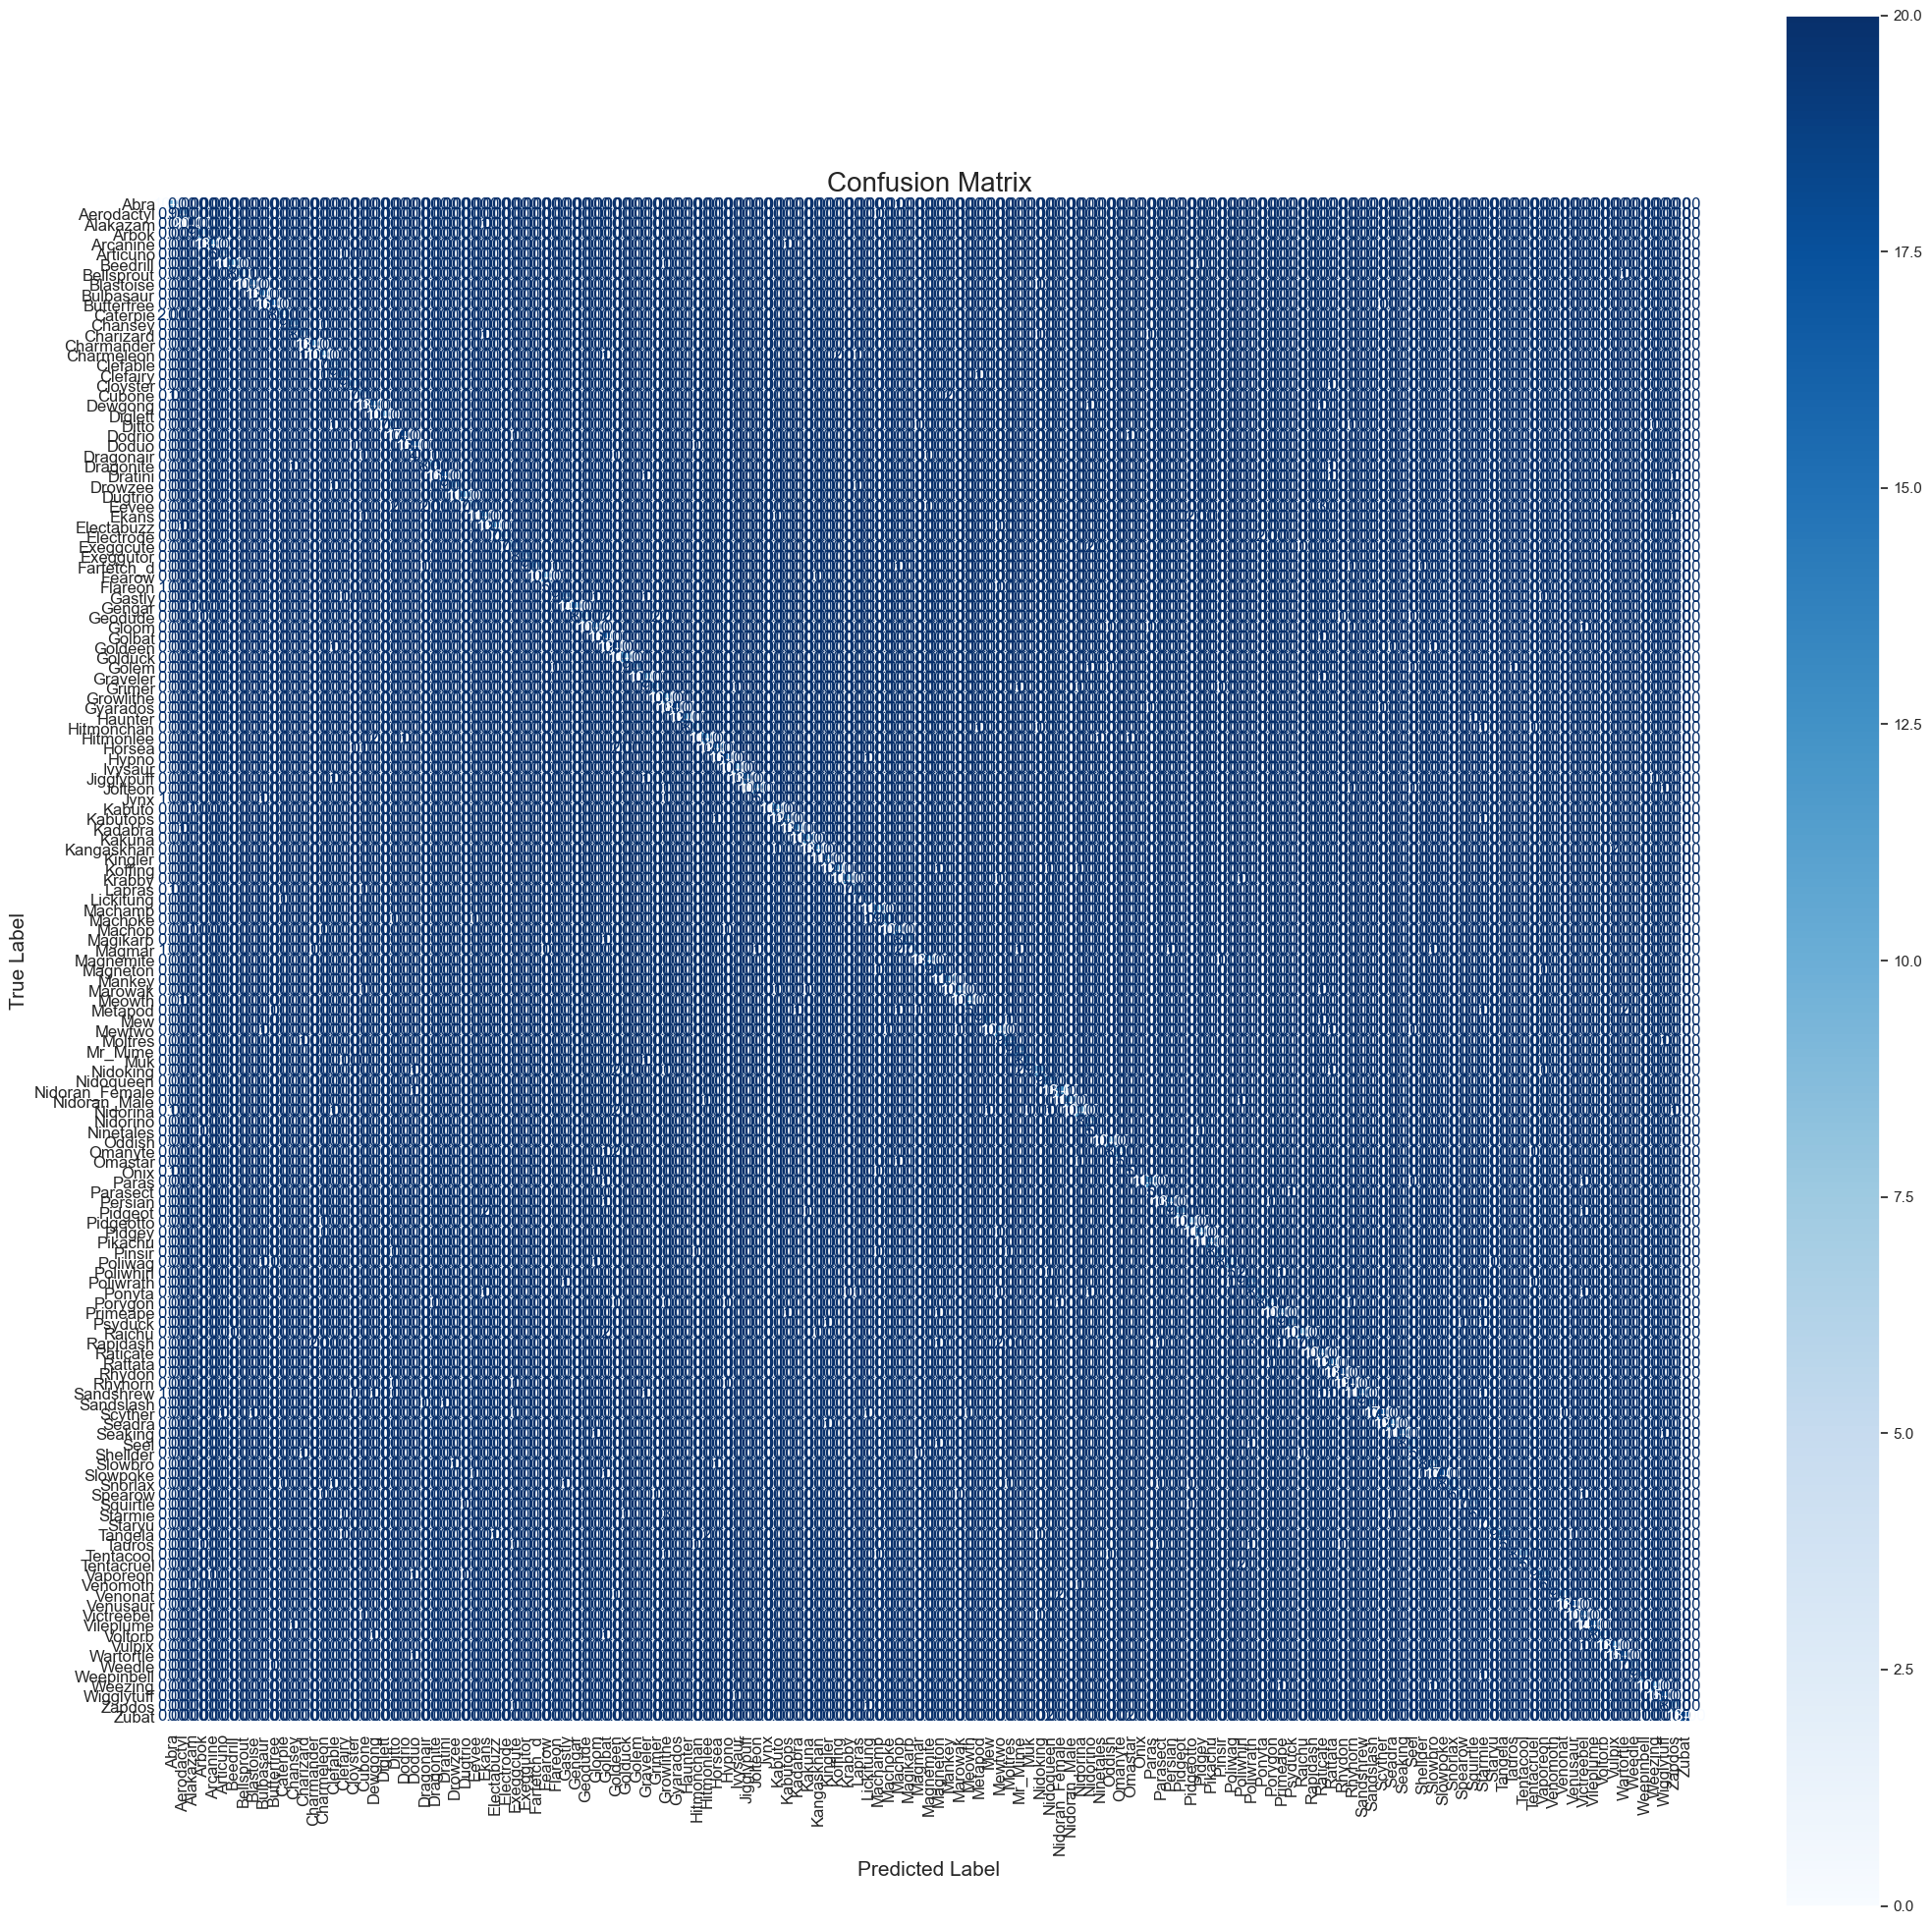

In [25]:
# Reset the model
# input_shape = (img_height, img_width, 3)
# n_classes = len(class_names)
# optimizer = "Adam"
# learning_rate = .0001
# metric='accuracy'
# num_epochs=15
# model = train_and_evaluate(train_ds, val_ds, input_shape, n_classes, optimizer, learning_rate, metric, num_epochs)


# Make predictions on the validation set
y_pred = []
y_true = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Convert the confusion matrix to a DataFrame for better readability
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Calculate the sum of misclassifications for each true class (row-wise)
misclassifications_by_true = cm_df.sum(axis=1) - np.diag(cm_df)

# Calculate the sum of misclassifications for each predicted class (column-wise)
misclassifications_by_pred = cm_df.sum(axis=0) - np.diag(cm_df)

# Identify the top classes with the most misclassifications
top_true_misclassifications = misclassifications_by_true.sort_values(ascending=False).head(10)
top_pred_misclassifications = misclassifications_by_pred.sort_values(ascending=False).head(10)

print("Top classes with the most misclassifications (by true labels):")
print(top_true_misclassifications)

print("\nTop classes with the most misclassifications (by predicted labels):")
print(top_pred_misclassifications)

# Plot the confusion matrix with a larger figure and smaller fonts
fig, ax = plt.subplots(figsize=(25, 25))  # Increase the size as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='.2f')

# Reduce font sizes for better readability
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)
plt.show()

Woof, so thats a little hard to see lets take do a double click and take a closer look at the most unfair classes. From here you can see these trends:

In [26]:
# Code for double click on the confusion matrix
import plotly.express as px

# Plot the confusion matrix with Plotly
fig = px.imshow(cm_df, text_auto=True, aspect="auto", color_continuous_scale="Blues")
fig.update_layout(
    title='Confusion Matrix',
    xaxis_title='Predicted Label',
    yaxis_title='True Label',
    xaxis=dict(tickmode='array', tickvals=list(range(len(class_names))), ticktext=class_names, tickangle=90),
    yaxis=dict(tickmode='array', tickvals=list(range(len(class_names))), ticktext=class_names),
    autosize=False,
    width=2000,  # Adjust the width to your preference
    height=2000  # Adjust the height to your preference
)

# Add click event
def display_click_info(trace, points, selector):
    for point in points.point_inds:
        true_label = cm_df.index[point[0]]
        pred_label = cm_df.columns[point[1]]
        misclassified_samples = cm_df.iloc[point[0], point[1]]
        print(f"True Label: {true_label}, Predicted Label: {pred_label}, Misclassified Samples: {misclassified_samples}")

fig.data[0].on_click(display_click_info)

fig.show()

In [28]:

# Create a mask where the true label and predicted label are different and the value is > 0
mask = (cm_df > 1) & (~np.eye(cm_df.shape[0], dtype=bool))

# Apply the mask to the confusion matrix
filtered_cm_df = cm_df.where(mask, np.nan)

# Determine which rows and columns have non-NaN values
rows_with_values = filtered_cm_df.notna().any(axis=1)
cols_with_values = filtered_cm_df.notna().any(axis=0)

# Filter the confusion matrix
filtered_cm_df = filtered_cm_df.loc[rows_with_values, cols_with_values]

# Create the plot
fig = px.imshow(filtered_cm_df, text_auto=True, aspect="auto", color_continuous_scale="Blues")
fig.update_layout(
    title='Confusion Matrix (True != Predicted and Values > 2)',
    xaxis_title='Predicted Label',
    yaxis_title='True Label',
    xaxis=dict(
        tickmode='array',
        tickvals=list(range(filtered_cm_df.shape[1])),
        ticktext=[filtered_cm_df.columns[i] for i in range(filtered_cm_df.shape[1])],
        tickangle=90
    ),
    yaxis=dict(
        tickmode='array',
        tickvals=list(range(filtered_cm_df.shape[0])),
        ticktext=[filtered_cm_df.index[i] for i in range(filtered_cm_df.shape[0])]
    ),
    autosize=False,
    width=1000,  # Adjust the width to your preference
    height=2000  # Adjust the height to your preference
)



# Display the figure
fig.show()


#### *Learned Filter Weights*

and now lets take a closer look at the features that the model is learning...

Its important to understand the patterns / output of the fiters that our model has learned. As an illustrative example we will first display the learned weights at the first convolutional layer (32 filters)

A quick note on giving credit: User DigitalSreeni's channel https://www.youtube.com/watch?v=ho6JXE3EbZ8 helped me figure out this code.

As you look at the filter below you might ask why black and white filters? Remeber that these filters are 3D (e.g., for RGB images, they are typically 3x3x3), the code is only plotting the first channel (R channel) of each filter as is typical for understanding the structure and values or these weights.

In [30]:
#Understand the filters in the model
#Let us pick the first hidden layer as the layer of interest.
layer = model.layers #Conv layers at [ 0, 3, 6 , 9]
filters, biases = model.layers[0].get_weights()
print(layer)
# Filter is 3X3X3 by 64
print(layer[0].name, filters.shape)

[<Conv2D name=conv2d, built=True>, <BatchNormalization name=batch_normalization, built=True>, <MaxPooling2D name=max_pooling2d, built=True>, <Conv2D name=conv2d_1, built=True>, <BatchNormalization name=batch_normalization_1, built=True>, <MaxPooling2D name=max_pooling2d_1, built=True>, <Conv2D name=conv2d_2, built=True>, <BatchNormalization name=batch_normalization_2, built=True>, <MaxPooling2D name=max_pooling2d_2, built=True>, <Conv2D name=conv2d_3, built=True>, <BatchNormalization name=batch_normalization_3, built=True>, <MaxPooling2D name=max_pooling2d_3, built=True>, <Flatten name=flatten, built=True>, <Dense name=dense, built=True>, <Dropout name=dropout, built=True>, <Dense name=dense_1, built=True>]
conv2d (3, 3, 3, 32)


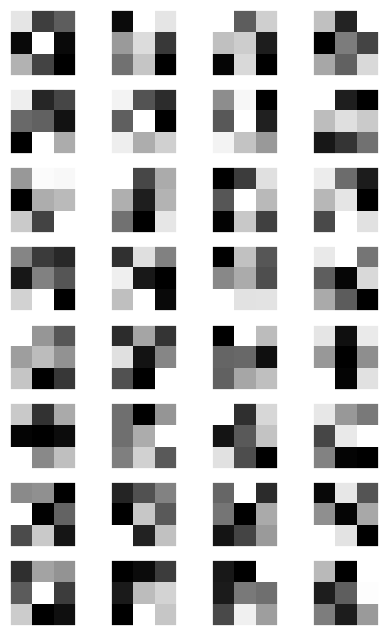

In [31]:
# plot filters for the first layer

fig1=plt.figure(figsize=(5, 8))
columns = 4
rows = 8
n_filters = columns * rows
for i in range(1, n_filters +1):
    f = filters[:, :, :, i-1]
    fig1 =plt.subplot(rows, columns, i)
    fig1.set_xticks([])  #Turn off axis
    fig1.set_yticks([])
    plt.imshow(f[:, :, 0], cmap='gray') #Show only the filters from 0th channel (R)
    #ix += 1
plt.show()

#### *Feature Map*
Now we would like to understand what the feature maps look like when we pass an image through our convolutional filter layers. This will help us understand what sort of features our model is extracting at various layers. We can see below that as images pass through our CNN, the layers progressively learn increasingly complex features, from basic edges and textures in early layers to intricate patterns and object parts in deeper layers.

In [32]:
#### Now plot filter outputs

#Define a new truncated model to only include the conv layers
conv_layer_index = [ 0, 3, 6 , 9]
outputs = [model.layers[i].output for i in conv_layer_index]
model_short = tf.keras.models.Model(inputs=model.inputs, outputs=outputs)
model_short.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        896 │ input_layer[0][0… │
│                     │ 32)               │            │ input_layer[0][0… │
│                     │                   │            │ input_layer[0][0… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 126, 126,  │        128 │ conv2d[3][0],     │
│ (BatchNormalizatio… │ 32)               │            │ conv2d[6][0],     │
│                     │                   │            │ conv2d[9][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[1]… │
│                     │ 64)               │            │ max_pooling2d[4]… │
│                     │                   │            │ max_pooling2d[7]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │        256 │ conv2d_1[3][0],   │
│ (BatchNormalizatio… │ 64)               │            │ conv2d_1[6][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        512 │ conv2d_2[3][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 12,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 389,312 (1.49 MB)

 Trainable params: 388,864 (1.48 MB)

 Non-trainable params: 448 (1.75 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


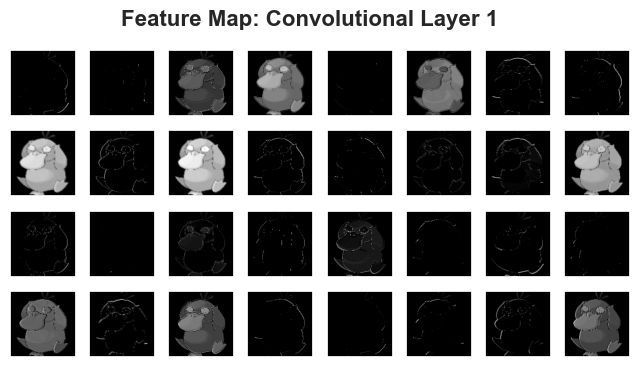

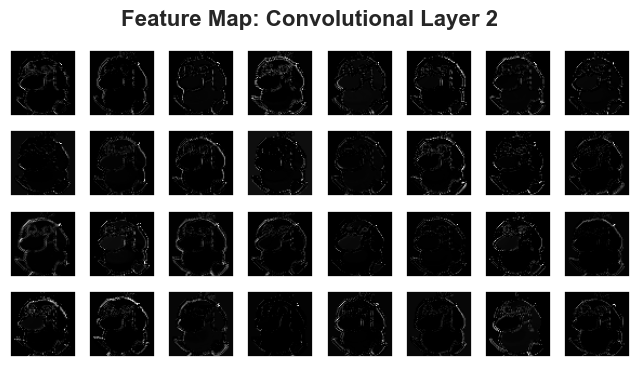

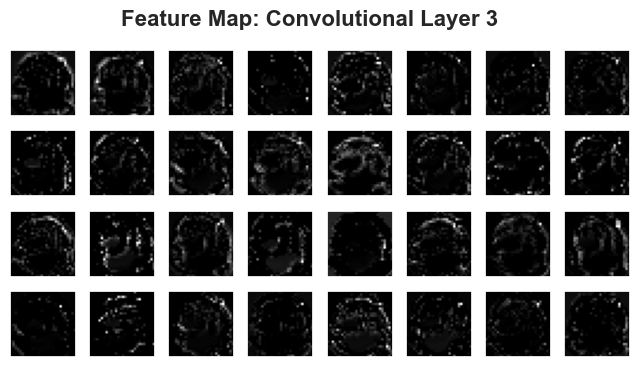

In [33]:
#Input shape to the model
img = load_img(r"C:\Users\tggus\OneDrive\Desktop\data\01_Scenario\Psyduck\54.png", target_size=(128, 128))

# convert the image to an array
img = img_to_array(img)
# expand dimensions to match the shape of model input
img = np.expand_dims(img, axis=0)

# Generate feature output by predicting on the input image
feature_output = model_short.predict(img)

columns = 8
rows = 4

# Iterate over the feature maps and add titles
for idx, ftr in enumerate(feature_output, start=1):
    fig = plt.figure(figsize=(8, 4))
    fig.suptitle(f'Feature Map: Convolutional Layer {idx}', fontsize=16, fontweight = 'bold')  # Add the title here
    for i in range(1, columns * rows + 1):
        ax = plt.subplot(rows, columns, i)
        ax.set_xticks([])  # Turn off axis
        ax.set_yticks([])
        plt.imshow(ftr[0, :, :, i - 1], cmap='gray')
    plt.show()


## 10. Understanding Model Performance Under Various Scenarios for Different Target Class Structures

Now we will visit the different scenarios we defined earlier to understand how it impacts model performance. Each of these have different use cases that can be helpful in their own way once deployed.

- **Model 1:**  Individual Pokemon
- **Model 2:**  By Pokemon Type
- **Model 3:**  By Evolution Group
- **Model 4:**  By Legendary Pokemon

First: Update the train and evaluate function so it no longer graphs

In [34]:
# Updated function to work better for looping (removed graphing etc.)

def train_and_evaluate2(train_ds, val_ds, input_shape, n_classes, optimizer, learning_rate, metric, num_epochs):
    # Build the model
    model = build_model(input_shape, n_classes, optimizer, learning_rate, metric)  # Assuming build_model is defined

    # Train the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=num_epochs,
        verbose=1
    )

    # Get the final metrics
    final_train_accuracy = history.history['accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]
    final_val_loss = history.history['val_loss'][-1]

    return model, final_train_accuracy, final_train_loss, final_val_accuracy, final_val_loss, history

Second create a loop of model class scenarios. For each of these the loop will ingest the new data structure and run the models. The hyperparameters are held constant for each scenario.

In [35]:
# Loop for all the different model class scenarios

scenarios = [dataset_path_Scenario_01,dataset_path_Scenario_02,dataset_path_Scenario_03,dataset_path_Scenario_04]
scenario_names = ['Full_List','Poke_Type','Evolution_Group','Legendary']

# Initialize lists to store the results
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []
models = []
histories = []  # To store history of each scenario
test_datasets = []  # To store test datasets of each scenario

for idx, scenario in enumerate(scenarios, start=1):
    print(f'FITTING SCENARIO {idx}...')

    # Define parameters
    batch_size = 32
    img_height = 128
    img_width = 128
    train_test_split = .2
    seed = 1234

    # Split the dataset into training and test sets
    train_ds_temp = image_dataset_from_directory(
        scenario,
        validation_split=train_test_split,
        subset="training",
        seed=seed,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )

    test_ds = image_dataset_from_directory(
        scenario,
        validation_split=train_test_split,
        subset="validation",
        seed=seed,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )

    # Store the test dataset for later evaluation
    test_datasets.append(test_ds)

    # Calculate the number of batches in the training dataset
    num_batches = tf.data.experimental.cardinality(train_ds_temp).numpy()

    # Calculate the number of batches for 75% and 25%
    num_batches_75 = int(num_batches * 0.75)
    num_batches_25 = num_batches - num_batches_75

    # Split the training dataset into 75% and 25%
    train_ds = train_ds_temp.take(num_batches_75)
    val_ds = train_ds_temp.skip(num_batches_75)

    # Count the number of files in each dataset
    num_files_train = sum(1 for _ in train_ds.unbatch())
    num_files_val = sum(1 for _ in val_ds.unbatch())
    num_files_test = sum(1 for _ in test_ds.unbatch())

    # Display the structure of the dataset
    print('NOTE THE ABOVE VALIDATION MEANS TEST DATA')
    print('-------------------------')
    print(f"Train dataset: {train_ds}")
    print(f"Val dataset: {val_ds}")
    print(f"Test dataset: {test_ds}")

    # Example: Inspect the class names
    class_names = train_ds_temp.class_names
    print('-------------------------')
    print(f"Class names: {class_names}")
    print('-------------------------')

    print(f"Number of files in train_ds: {num_files_train}")
    print(f"Number of files in val_ds: {num_files_val}")
    print(f"Number of files in test_ds: {num_files_test}")

    # Train and Evaluate
    input_shape = (img_height, img_width, 3)
    n_classes = len(class_names)
    optimizer = "Adam"
    learning_rate = .0001
    metric = 'accuracy'
    num_epochs = 15

    model, final_train_accuracy, final_train_loss, final_val_accuracy, final_val_loss, history = train_and_evaluate2(
        train_ds, val_ds, input_shape, n_classes, optimizer, learning_rate, metric, num_epochs
    )

    # Append the results to the lists
    train_accuracies.append(final_train_accuracy)
    train_losses.append(final_train_loss)
    val_accuracies.append(final_val_accuracy)
    val_losses.append(final_val_loss)
    models.append(model)
    histories.append(history)

    # Print the final results
    print(f'Scenario {idx} - Final Training Accuracy: {final_train_accuracy:.4f}')
    print(f'Scenario {idx} - Final Training Loss: {final_train_loss:.4f}')
    print(f'Scenario {idx} - Final Validation Accuracy: {final_val_accuracy:.4f}')
    print(f'Scenario {idx} - Final Validation Loss: {final_val_loss:.4f}')
    print('-------------------------')

FITTING SCENARIO 1...
Found 9514 files belonging to 151 classes.
Using 7612 files for training.
Found 9514 files belonging to 151 classes.
Using 1902 files for validation.
NOTE THE ABOVE VALIDATION MEANS TEST DATA
-------------------------
Train dataset: <_TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Val dataset: <_SkipDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Test dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
-------------------------
Class names: ['Abra', 'Aerodactyl', 'Alakazam', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 

Finally Graph Results (Summary View). Here we can see a couple key things.
- We see improvement by each scenario type with the full list performing the worst (still quite well) and the lengendary class approach performing the best.
- This should be no suprise because each of these class approaches were designed to remove slightly more variation every time


In [36]:
# Create figure
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot all scenarios training accuracy
for i, history in enumerate(histories):
    hist_dict = history.history
    axs[0, 0].plot(hist_dict['accuracy'], label=f'Model {i+1} | {scenario_names[i]}')

axs[0, 0].set_title('All Models Training Accuracy')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Training Accuracy')
axs[0, 0].legend()

# Plot all scenarios' training loss
for i, history in enumerate(histories):
    hist_dict = history.history
    axs[0, 1].plot(hist_dict['loss'], label=f'Model {i+1} | {scenario_names[i]}')

axs[0, 1].set_title('All Models Training Loss')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Training Loss')
axs[0, 1].legend()

# Plot all scenarios' validation accuracy
for i, history in enumerate(histories):
    hist_dict = history.history
    axs[1, 0].plot(hist_dict['val_accuracy'], label=f'Model {i+1} | {scenario_names[i]}')

axs[1, 0].set_title('All Models Validation Accuracy')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Validation Accuracy')
axs[1, 0].legend()

# Plot all scenarios' validation loss
for i, history in enumerate(histories):
    hist_dict = history.history
    axs[1, 1].plot(hist_dict['val_loss'], label=f'Model {i+1} | {scenario_names[i]}')

axs[1, 1].set_title('All Models Validation Loss')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Validation Loss')
axs[1, 1].legend()


plt.tight_layout()
plt.show()

## 11. Generalization
Finally we will see how these different model structures perform with unseen data (i.e. Generalization).

GENERALIZATION
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8062 - loss: 0.9737
Model 1
Test Loss: 0.9470597505569458
Test Accuracy: 0.8054679036140442
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.8291 - loss: 0.7037
Model 2
Test Loss: 0.7420035600662231
Test Accuracy: 0.8191377520561218
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.8506 - loss: 0.6633
Model 3
Test Loss: 0.7061421275138855
Test Accuracy: 0.8454258441925049
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9755 - loss: 0.2402
Model 4
Test Loss: 0.2469007521867752
Test Accuracy: 0.9773921966552734


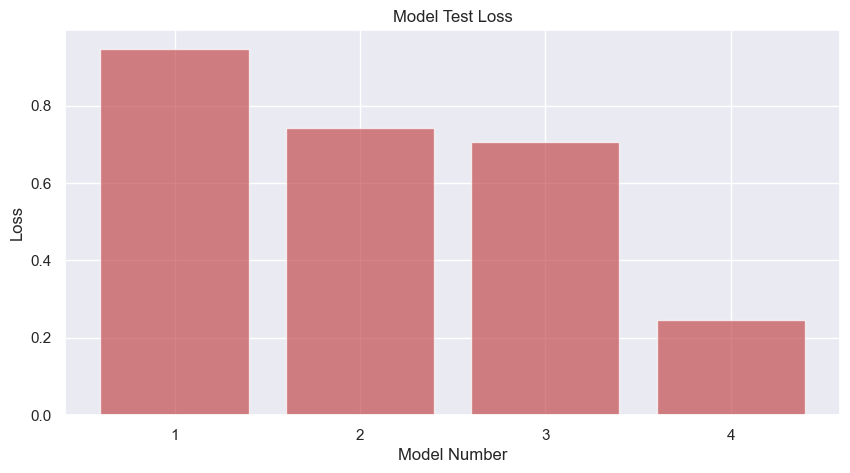

In [37]:
# Evaluate the model on training and test dataset (probability threshold of .5 is default)
print('GENERALIZATION')
n = 0
test_losses = []
test_accuracies = []

for model in models:
    evaluation_results = model.evaluate(test_datasets[n])
    print(f'Model {n+1}')
    print(f"Test Loss: {evaluation_results[0]}")
    print(f"Test Accuracy: {evaluation_results[1]}")
    test_losses.append(evaluation_results[0])
    test_accuracies.append(evaluation_results[1])
    n += 1

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.bar(range(1, n+1), test_accuracies, color='b', alpha=0.7)
plt.title('Model Test Accuracy')
plt.xlabel('Model Number')
plt.ylabel('Accuracy')
plt.xticks(range(1, n+1))
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
plt.grid(True, axis='y')
plt.show()

# Plotting loss
plt.figure(figsize=(10, 5))
plt.bar(range(1, n+1), test_losses, color='r', alpha=0.7)
plt.title('Model Test Loss')
plt.xlabel('Model Number')
plt.ylabel('Loss')
plt.xticks(range(1, n+1))
plt.grid(True, axis='y')
plt.show()